In [5]:
import requests
from bs4 import BeautifulSoup
import lxml
import nltk
import pandas as pd
import re
import bs4
import requests
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm')
pd.set_option('display.max_colwidth', 200)
%matplotlib inline
nltk.download('punkt')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
import requests
from bs4 import BeautifulSoup
import lxml
import re

def scrape_and_split_text(url, max_words=18):
    """Scrapes text from a webpage, splits into sentences, and breaks long sentences."""

    headers = {
        'User-Agent': 'Mozilla/5.0',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()

        soup = BeautifulSoup(response.content, 'lxml')
        for script in soup(["script", "style"]):
            script.extract()
        text = soup.get_text(separator=' ')

        # Split into sentences
        sentences = re.split(r'(?<=[.!?])\s+', text)

        # Break long sentences
        split_sentences = []
        for sentence in sentences:
            while len(sentence.split()) > max_words:
                split_index = sentence.rfind(' ', 0, max_words)
                if split_index == -1:  # Handle cases where no suitable space is found
                    split_index = max_words
                split_sentences.append(sentence[:split_index].strip())
                sentence = sentence[split_index:].strip()
            split_sentences.append(sentence.strip())

        return split_sentences

    except requests.RequestException as e:
        print(f"Error fetching page: {e}")
        return None

In [8]:
url = "https://www.hdfcergo.com/health-insurance/individual-health-insurance/"
input_text = scrape_and_split_text(url)
df = pd.Series( (v for v in input_text) )

In [9]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################
    return [ent1.strip(), ent2.strip()]

In [10]:
entity_pairs = []

for i in tqdm(df):
    entity_pairs.append(get_entities(i))

100%|██████████| 2150/2150 [00:09<00:00, 224.13it/s]


In [11]:

def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object
    matcher = Matcher(nlp.vocab)

    #define the pattern
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

    matcher.add("matching_1", [pattern])

    matches = matcher(doc)
    # print(matches)
    k = len(matches) - 1

    # Error Handling
    if not matches:
      return None  # Or return a default value like "" or "NO_RELATION_FOUND"

    # Only proceed if there's at least one match
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]]  # This should now be safe


    return(span.text)

relations = [get_relation(i) for i in df]

In [12]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df.sort_values(['source'], ascending=[True])

,source,target,edge
0,,,Individual
1425,,age,based on
1424,,,vary
1423,,,members
1422,,all,choice for
...,...,...,...
969,younger you,health insurance,get
737,yourself,65 years,get
1814,| PET HDFC,ERGO Paws,Apply
542,’s,,Let


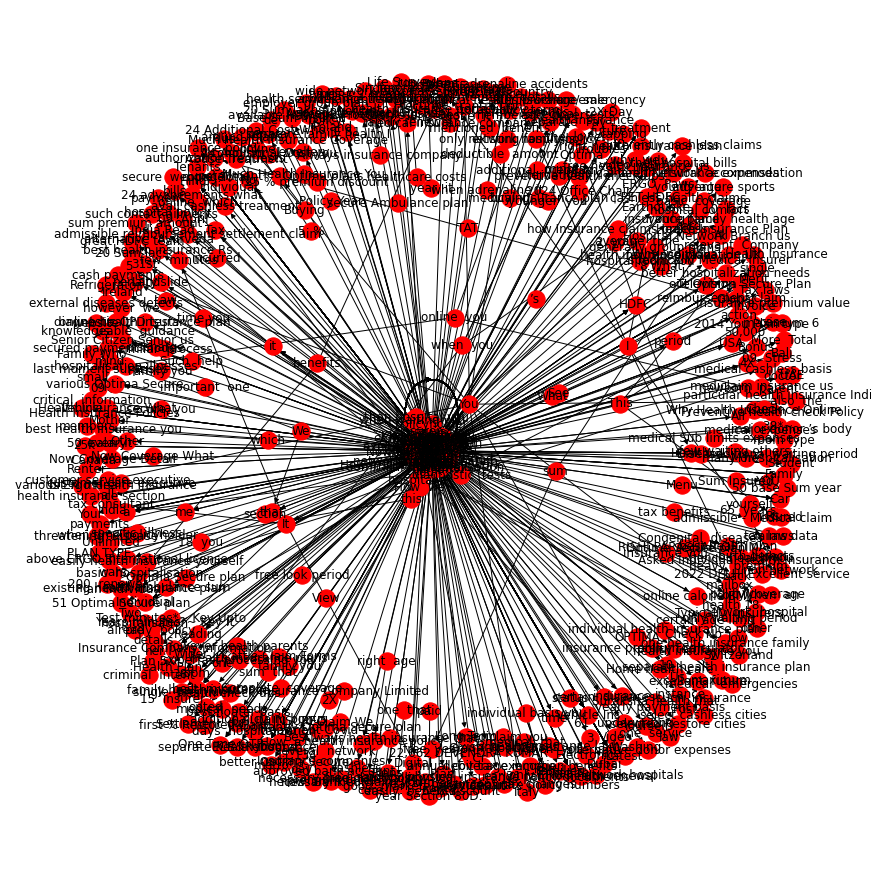

In [13]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [14]:
# Function to check sentence length
def is_short_sentence(sentence):
    words = sentence.split()  # Split into words
    return len(words) <= 2

# Filter the DataFrame
column_to_check = 'target'  # Replace with the actual column name
kg_df_filtered = kg_df[~kg_df[column_to_check].apply(is_short_sentence)]

print("Original DataFrame:")
print(kg_df)

print("\nFiltered DataFrame (removed short sentences in column '" + column_to_check + "'):")
print(len(kg_df_filtered))

Original DataFrame:
     source                      target        edge
0                                        Individual
1                                         Insurance
2                                               Buy
3                                          Personal
4                                         Mediclaim
...     ...                         ...         ...
2145                                            All
2146                                             EV
2147                                           Gyan
2148                                         Corner
2149         Hospital Network Branch us        Know

[2150 rows x 3 columns]

Filtered DataFrame (removed short sentences in column 'target'):
122


In [15]:
import pandas as pd
import spacy #for entity recognition
from spacy import displacy
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-mpnet-base-v2')
nlp = spacy.load('en_core_web_sm')
def generate_response(query):
    best=""
    max_score=-1
    query_embedding = model.encode(query, convert_to_tensor=True)
    for index, row in kg_df_filtered.iterrows():
        source_embedding = model.encode(row['source'], convert_to_tensor=True)
        target_embedding = model.encode(row['target'], convert_to_tensor=True)
        source_similarity = util.cos_sim(query_embedding, source_embedding)
        target_similarity = util.cos_sim(query_embedding, target_embedding)
        if max(source_similarity, target_similarity) > max_score:
            best = f"{row['source']} {row['edge']} {row['target']}"
            max_score = max(source_similarity, target_similarity)
    return best


In [3]:
def chat():
    # Example Usage
    while True:
        user_input = input("You: ")
        if user_input.lower() == "exit":
            break
        response = generate_response(user_input)
        print("Bot:", response)

In [16]:
def helper(req):
    response = generate_response(req)
    return response

In [17]:
helper("what is hdfc ergo")

'HDFC we have + Health care centers'

In [17]:
!pip install -q streamlit

In [22]:
import streamlit as st
# from chatterbot import ChatBot
# from chatterbot.trainers import ChatterBotCorpusTrainer

# Streamlit app
def main():
    st.title("Chatbot with Streamlit")

    # Get user input
    user_input = st.text_input("You:", "")

    if st.button("Send"):
        # Get response from chatbot
        response = helper(user_input)
        
        # Display response
        st.text("ChatBot: {}".format(response))


if __name__ == "__main__":
    main()


Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Streamlit requires raw Python (.py) files, not .ipynb.
For more information, please see https://docs.streamlit.io
